In [74]:
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np

## example

```bash
nohup parallel 'python3 experiment_dbpedia_14.py --group_id dbpedia_14_20240109 --n_sample_from 5 --n_sample_to 25 --n_trials 10 --verification {1} --strategy {2}' ::: themselves dataset ::: normal super > results/ex_20240109.log &

In [75]:
# group_id_list = ["truthfulqa_20240208"]
group_id_list = ["dbpedia_14_20240109", "dbpedia_14_20240110"]
# load result
results = []
for group_id in group_id_list:
    result_files = glob.glob(f"./results/{group_id}/*.pickle")
    for file in result_files:
        with open(file, "rb") as f:
            tmp = pickle.load(f)
            # print("verification: ", tmp["args"].verification)
            # print("strategy: ", tmp["args"].strategy)
            if tmp["args"].strategy == "super":
                results.append(tmp)
            # results.append(tmp)

# create plots folder
os.makedirs(f"./plots/{group_id_list[0]}/", exist_ok=True)

print(len(results[0]))

5


In [76]:
# make results into dataframe
df_columns = ["model", "label", "accuracy", "precision", "TP", "TN", "FP", "FN", "#samples", "n_trials", "strategy", "n_data", "dataset"]
df_data = []
time_elapsed = 0
ex_id = ""
args = {}
for r in results:
    # when different args, display it
    if args != r["args"]:
        print("#data: ", len(df_data))
        print("experiment settings: ", r["args"])
    args = r["args"]
    if "dataset" in args:
        dataset = args.dataset
    else:
        dataset = ""
    n_trials = args.n_trials
    max_retry = args.max_retry
    model = args.model
    strategy = args.strategy
    if r.get("topics_dict"):
        topics_dict = r["topics_dict"]
        print(f"#topics/#items: {len(topics_dict)}/{sum([len(topics_dict[k]) for k in topics_dict.keys()])}")
        print(f"most frequent topic: {max(topics_dict, key=lambda x: len(topics_dict[x]))}, {len(topics_dict[max(topics_dict, key=lambda x: len(topics_dict[x]))])} items")
        print(f"average #items: {sum([len(topics_dict[k]) for k in topics_dict.keys()])/len(topics_dict)}")
    else:
        topics_dict = {}
    # if args.verification == "themselves" or strategy == "normal":
    #     continue
    for trial in r["result"]:
        for sample in trial:
            if topics_dict == {}:
                n_data = 1
            else:
                n_data = len(topics_dict[sample["class label"]])
            df_data.append([
                model,
                sample["class label"],
                sample["accuracy"],
                sample["precision"],
                sample["TP"],
                sample["TN"],
                sample["FP"],
                sample["FN"],
                sample["n_samples"],
                n_trials,
                strategy,
                n_data,
                dataset,
            ])
    time_elapsed = int(r["finish_time"]) - int(r["start_time"])
    ex_id = r["experiment_id"]
df_results = pd.DataFrame(df_data, columns=df_columns)
print("---")
print("time elapsed: ", time_elapsed)
print("experiment id: ", ex_id)
print("#data: ", len(df_data))
# print("total #data should be:", 14*n_trials*5)
print(df_results.loc[0:14])

#data:  0
experiment settings:  Namespace(group_id='dbpedia_14_20240109', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct', logging=True, max_retry=3, test=False, strategy='super', verification='dataset')
#data:  509
experiment settings:  Namespace(group_id='dbpedia_14_20240109', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct', logging=True, max_retry=3, test=False, strategy='super', verification='themselves')
---
time elapsed:  12980
experiment id:  853dd0caeb766a622f9f96a97587581b
#data:  1187
                     model                   label  accuracy  precision  TP  \
0   gpt-3.5-turbo-instruct  EducationalInstitution       0.3        0.6   3   
1   gpt-3.5-turbo-instruct            OfficeHolder       0.7        0.6   3   
2   gpt-3.5-turbo-instruct    MeanOfTransportation       0.8        1.0   5   
3   gpt-3.5-turbo-instruct                Building       0.5        0.8   4   
4   gpt-3.5-t

In [77]:
# group by n_sample
res_g_sample = df_results.groupby(by=["#samples"], as_index=False)
w_avg = res_g_sample.apply(
    lambda row: np.average(row[["accuracy"]], axis=0, weights=row["n_data"])
)
w_prec = res_g_sample.apply(
    lambda row: np.average(row[["precision"]], axis=0, weights=row["n_data"])
)
w_avg = pd.concat([pd.Series(res_g_sample["#samples"].groups.keys()), w_avg, w_prec], axis=1)
w_avg.columns = [ "#samples", "accuracy", "precision"]
w_avg = w_avg.explode(['accuracy', 'precision']).reset_index(drop=True)
cor = w_avg[['#samples', 'accuracy', 'precision']].corr()

# res_g_sample = res_g_sample.drop(columns=["n_trials"])

# print(res_g_sample.to_latex(escape=True,index=False))
print(w_avg.to_latex(escape=True, index=False))
print(cor.to_latex(escape=True))

\begin{tabular}{rll}
\toprule
\#samples & accuracy & precision \\
\midrule
5 & 0.620576 & 0.765432 \\
10 & 0.541903 & 0.670445 \\
15 & 0.549862 & 0.624793 \\
20 & 0.506277 & 0.574255 \\
25 & 0.497636 & 0.609273 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & \#samples & accuracy & precision \\
\midrule
\#samples & 1.000000 & -0.914650 & -0.875589 \\
accuracy & -0.914650 & 1.000000 & 0.932494 \\
precision & -0.875589 & 0.932494 & 1.000000 \\
\bottomrule
\end{tabular}


In [78]:
def plot_acc_prec_summary(df: DataFrame, fontsize=12, target=["accuracy"], compare_with={}, figsize=(16, 8)):
    # df_target = df.groupby(by=["strategy", "#samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1)
    # plt.title(f"{model}")
    plt.xlabel("#samples", fontsize=fontsize)
    plt.ylabel("/".join(target), fontsize=fontsize)
    plt.ylim(0, 1.05)
    
    # accuracy should be weighted by n_data
    labels = []
    for idx, (l, klass) in enumerate(df_target.groupby(by="strategy")):
        # subplt = plt.subplot(1, 2, idx+1)
        # subplt.set_title(l, fontsize=fontsize)
        # subplt.set_ylim(0, 1.05)
        # subplt.set_xlabel("#samples", fontsize=fontsize)

        plot_data = {}
        n_list = []
        for n_sample, data in klass.groupby(by="#samples"):
            n_list.append(n_sample)
            for t in target:
                weighted = np.average(data[t], weights=data["n_data"])
                plot_data[t] = plot_data.get(t, []) + [weighted]
        for t in target:
            plt.plot(n_list, plot_data[t], label=f"{t} - {l}")
        plt.xticks(n_list)
        plt.xlim(min(n_list)-1, max(n_list)+1)
    if compare_with != {}:
        for k, v in compare_with.items():
            plt.axhline(y=v, color="gray", linestyle="--", label=f"{k} ({v})")
    
    # plt.title("accuracy", fontsize=fontsize)
    # plt.ylabel("accuracy", fontsize=fontsize)
    # 
    # precs_by_n_sample = []
    # accs_by_n_sample = []
    # n_list = []
    # for n_sample, data in df.groupby(by="#samples"):
    #     n_list.append(n_sample)
    #     precs_by_n_sample.append(data["precision"].mean())
    #     accs_by_n_sample.append(data["accuracy"].mean())
    # plt.plot(n_list, precs_by_n_sample, label="precision")
    # plt.plot(n_list, accs_by_n_sample, label="accuracy")
    # plt.xticks(n_list)

    plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2, fontsize=fontsize)
    # save images
    plt.savefig(f"./plots/{group_id_list[0]}/summary-{"-".join(target)}.pdf")

## Benchmark score on TruthfulQA dataset 
source: [https://github.com/sylinrl/truthfulqa](https://github.com/sylinrl/truthfulqa)

### %true
InstructGPT: 0.48

Comparable with precision
precisionはTN, FNを用いないため，負例ピックアップstrategyによる差がない(比較する意味がない)．
しかし，検証時のtemperatureのランダム性によって，precisionが変動する．


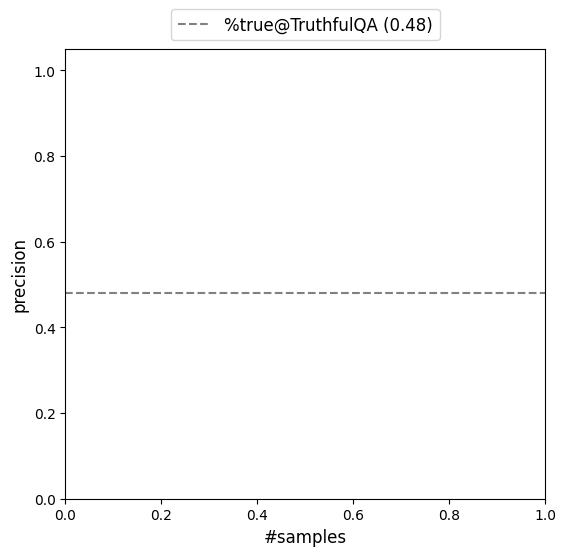

In [79]:
df_results_normal = df_results[df_results["strategy"] == "normal"]
plot_acc_prec_summary(df_results_normal, fontsize=12, target=["precision"], compare_with={"%true@TruthfulQA":0.48}, figsize=(6, 6))

## TruthfulQA dataset
### MC1
Comparable with Accuracy

InstructGPT: 


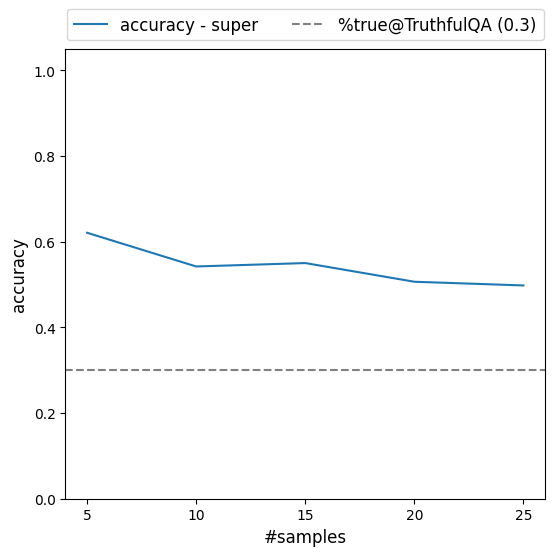

In [80]:
plot_acc_prec_summary(df_results, fontsize=12, target=["accuracy"], compare_with={"%true@TruthfulQA":0.3}, figsize=(6, 6))

In [81]:
# plot accuracy and precision with df_results
# x axis: label
# y axis: accuracy/precision (average of all trials)
# group by n_sample

def plot_acc_prec_by_verification(df: DataFrame, verification="dataset", fontsize=12):
    # df_target = df.groupby(by=["strategy", "#samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)
    # plt.set_cmap("tab20")
    cm = plt.get_cmap("tab20")
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    # plt.xlabel("#samples")
    # plt.ylim(0, 1)

    sub_acc = plt.subplot(1, 2, 1)
    # sub_acc.set_title("accuracy", fontsize=fontsize)
    sub_acc.set_xlabel("#samples", fontsize=fontsize)
    sub_acc.set_ylabel("accuracy", fontsize=fontsize)
    sub_acc.set_ylim(0, 1.05)
    
    sub_prec = plt.subplot(1, 2, 2)
    # sub_prec.set_title("precision", fontsize=fontsize)
    sub_prec.set_xlabel("#samples", fontsize=fontsize)
    sub_prec.set_ylabel("precision", fontsize=fontsize)
    sub_prec.set_ylim(0, 1.05)
    
    labels = []
    n_list = []
    # get average of accuracy and precision for each label group by n_sample
    for l, klass in df_target.groupby(by="label"):
        precs_by_n_sample = []
        accs_by_n_sample = []
        n_list = []
        labels.append(l)
        for n_sample, data in klass.groupby(by="#samples"):
            n_list.append(n_sample)
            weighted_acc = np.average(data["accuracy"], weights=data["n_data"])
            weighted_prec = np.average(data["precision"], weights=data["n_data"])
            precs_by_n_sample.append(weighted_prec)
            accs_by_n_sample.append(weighted_acc)
        sub_prec.plot(n_list, precs_by_n_sample, label=l, color=cm(labels.index(l)))
        sub_acc.plot(n_list, accs_by_n_sample, label=l, color=cm(labels.index(l)))
    # plt.xticks(n_list)
    plt.legend(labels, loc="lower center", bbox_to_anchor=(0, 1), ncol=5, fontsize=fontsize)
    
    # save images
    plt.savefig(f"./plots/{group_id_list[0]}/{strategy}-{verification}-{ex_id}.pdf")


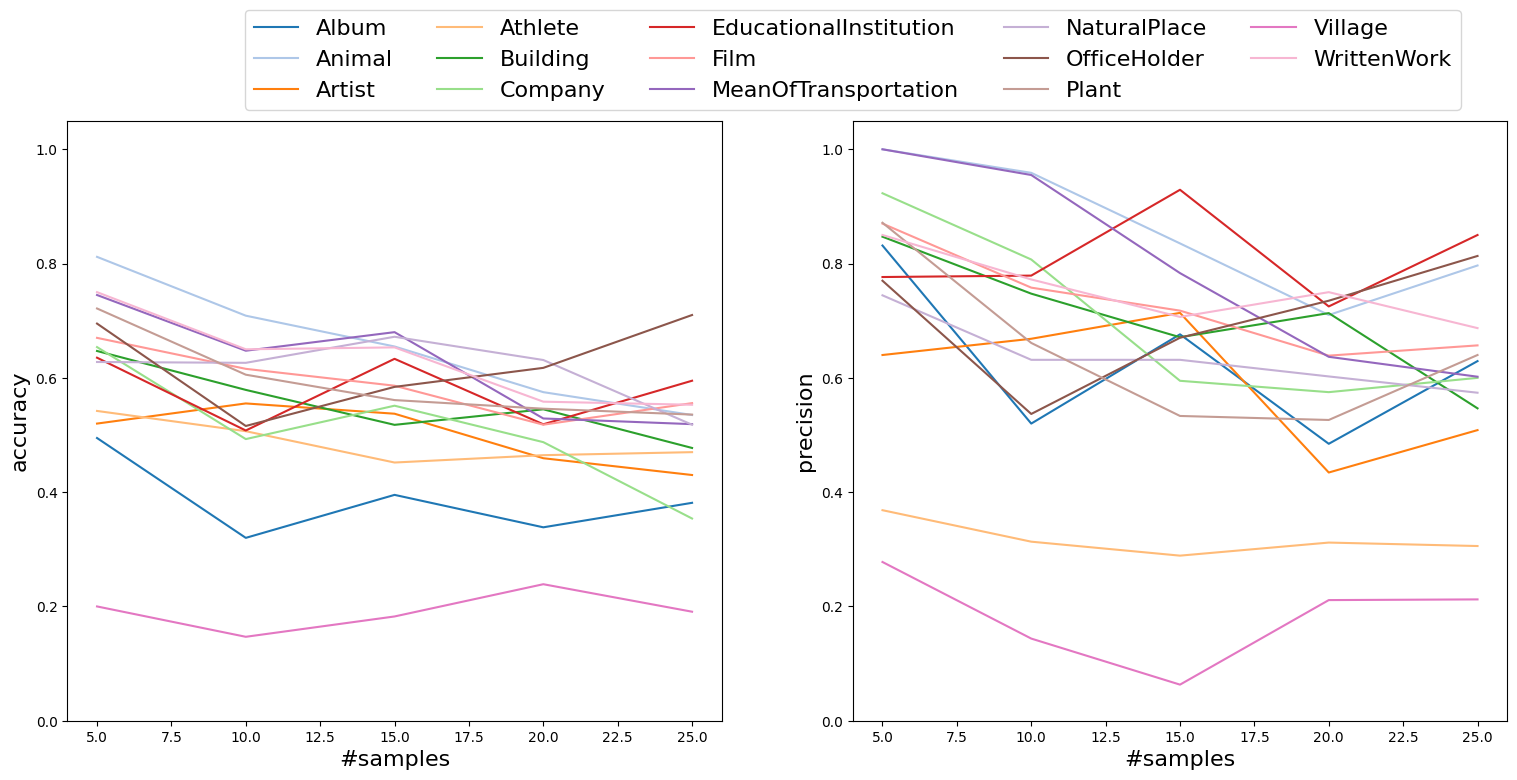

In [82]:
plot_acc_prec_by_verification(df_results, verification="dataset", fontsize=16)

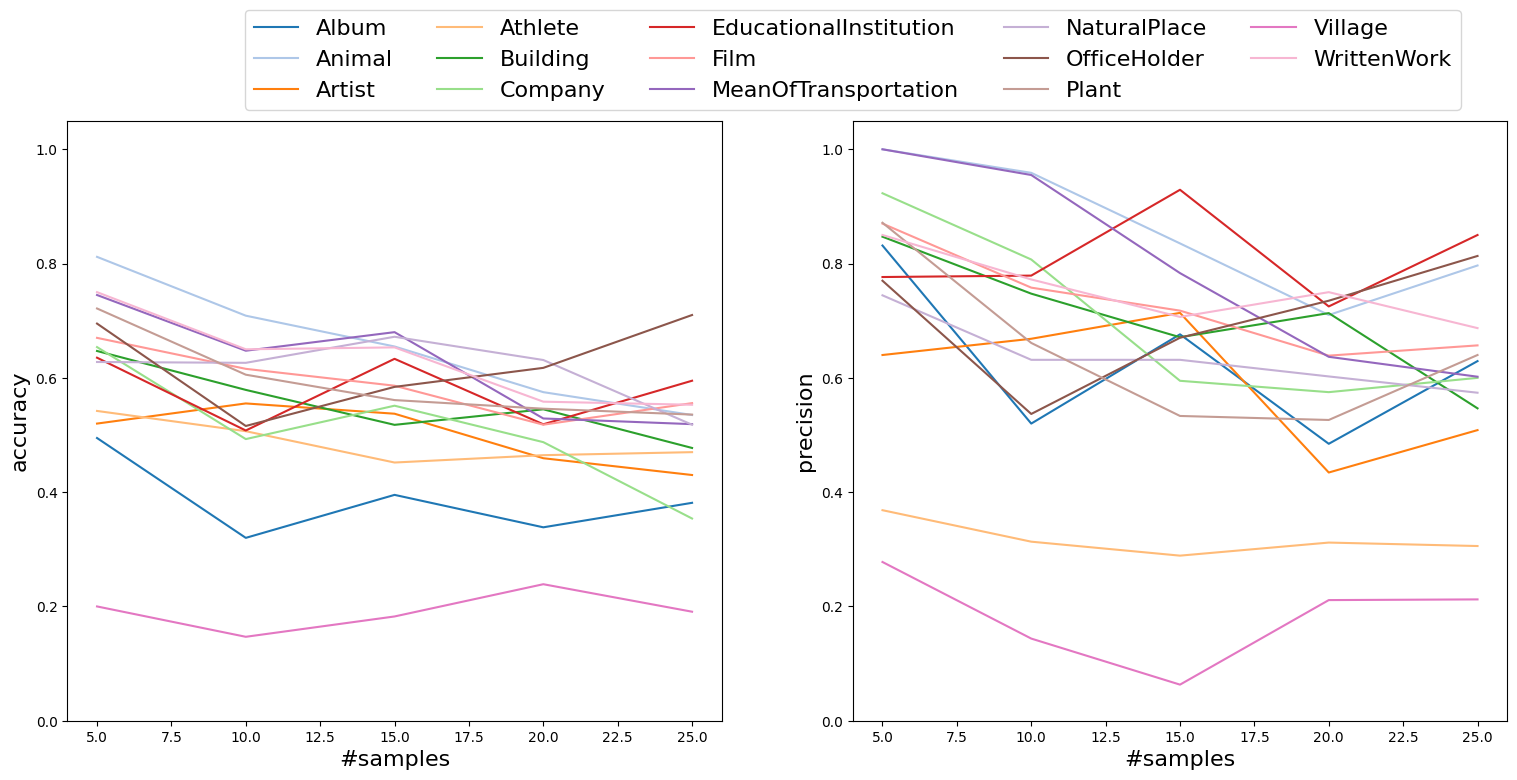

In [83]:
plot_acc_prec_by_verification(df_results, verification="themselves", fontsize=16)